# 06 — Option Pricing & Monte Carlo Simulation (Black–Scholes & GBM)

This notebook builds the derivative-pricing and risk-neutral simulation layer of the entire quantitative pipeline.  
Using the market data engineered in Notebook 01 and the statistical diagnostics from earlier notebooks, it implements both closed-form Black–Scholes models** and **Monte Carlo simulation under Geometric Brownian Motion (GBM) to price European and path-dependent options. It acts as the bridge between statistical market modeling and the construction of forward-looking valuation tools, grounding the project in industry-standard pricing techniques used in trading, structuring, and risk management.

### Objectives
- Implement Black–Scholes analytical pricing for European calls and puts.  
- Compute Greeks (Δ, Γ, vega, θ, ρ) to quantify sensitivity to model parameters.  
- Extract Implied Volatility (IV) and construct volatility smiles.  
- Simulate Geometric Brownian Motion (GBM) under the risk-neutral measure.  
- Price European options via Monte Carlo and compare against closed-form values.  
- Price barrier options (down-and-out) using path-dependent simulation.  
- Compute Monte Carlo Greeks using pathwise and likelihood-ratio estimators.  
- Export pricing surfaces and simulation results for visualization and dashboards.

### Inputs
| File | Description |
|------|-------------|
| `/data/processed/clean_prices.csv` | Cleaned underlying spot price series from Notebook 01. |
| (Optional) `/data/powerbi/volatility_panel.csv` | Volatility estimates from Notebook 04 for IV comparison. |

### Outputs
| File | Description |
|------|-------------|
| `/figures/06.Pricing/bs_price_grid.png` | Black–Scholes price surface across strikes and maturities. |
| `/figures/06.Pricing/vol_smile.png` | Implied-volatility smile for selected maturities. |
| `/figures/06.Pricing/mc_european_convergence.png` | Monte Carlo convergence plot for European call. |
| `/figures/06.Pricing/barrier_path_examples.png` | Sample simulated paths for barrier options. |
| `/data/powerbi/pricing_panel.csv` | Unified pricing output for BI dashboards. |

### Pricing Models Implemented
| Model | Purpose |
|-------|---------|
| **Black–Scholes (closed form)** | Baseline pricing under lognormal dynamics and constant volatility. |
| **Greeks (analytical)** | Sensitivity measures required for hedging and risk assessment. |
| **Implied Volatility** | Market-consistent volatility derived by inverting Black–Scholes. |
| **GBM Monte Carlo** | Simulation-based valuation for European and exotic options. |
| **Barrier Monte Carlo** | Pricing of path-dependent options with knock-out mechanisms. |
| **Monte Carlo Greeks** | Sensitivity estimation in simulation-based models. |

### Notebook Structure
1. **Load Market Data & Setup**  
   Import underlying prices, compute basic statistics, configure r, T-grid and strikes.
2. **Black–Scholes Analytical Pricing**  
   Implement call/put pricing, Greeks, and price surfaces.
3. **Implied Volatility & Smile Construction**  
   Numerical inversion of Black–Scholes and IV visualization.
4. **Monte Carlo Simulation under GBM**  
   Generate paths under risk-neutral dynamics and price European options.
5. **Barrier Option Pricing**  
   Implement down-and-out barrier pricing and analyse path-dependence.
6. **Monte Carlo Greeks**  
   Compute delta, gamma, vega using pathwise/LR estimators.
7. **Export Pricing Panel**  
   Save final pricing results for BI dashboards and downstream use.
8. **Conclusions**  
   Compare analytical vs Monte Carlo methods and discuss hedging implications.

This notebook provides the valuation engine of the project: it implements fundamental pricing tools used by quants, traders and risk managers, and connects statistical market modeling with derivative valuation and simulation-based analytics.


# 1. Load market data & basic setup

This opening section selects the underlying asset for option pricing, validates its historical price series, computes basic return statistics, and fixes the core parameters that will drive all subsequent Black–Scholes and Monte Carlo valuations. Everything is built on top of the cleaned panel generated in the data-engineering notebook, ensuring consistency across the whole project.

## 1.1 Loading the underlying from the multi-asset panel

We start by importing the `clean_prices.csv` file, which contains adjusted prices for several indices and FX rates:

- EURUSD  
- SP500  
- IBEX35  
- NASDAQ100  
- EUROSTOXX50  
- VIX  

The notebook explicitly chooses **SP500** as the underlying for option pricing. The checks on:

- monotonic time index  
- absence of missing values  

guarantee that both analytical and Monte Carlo pricing routines will operate on a clean, continuous price path, avoiding bias from data errors or gaps.

## 1.2 Price history and return diagnostics

Two plots summarise the historical behaviour of the S&P 500:

1. **Spot price level**  
   - From around 1,400 points in early 2000 to nearly 5,900 points at the end of the sample.  
   - Distinct drawdowns are visible during the dot-com unwind, the Global Financial Crisis (2008–2009), the Euro-area stress (2011), and the COVID shock (2020), followed by strong recoveries.

2. **Daily log-returns**  
   - Mostly contained within a ±3% band in normal times.  
   - Massive spikes during crises, with daily losses close to −10% and occasional large positive rebounds.  
   - Clear volatility clustering: calm stretches with small returns alternated with short bursts of extremely high volatility.

These features confirm that, even though the pricing will be done under a simplified GBM/Black–Scholes world, the empirical data exhibit the usual equity stylised facts (fat tails, volatility clustering), which is important when interpreting the limitations of the models later.


## 1.3 Basic return statistics and interpretation

From the log-return series, the notebook computes:
- Annualised historical drift**: ≈ 5.41%  
- Annualised historical volatility**: ≈ 19.09%

Interpretation:

- A 5–6% annual drift is broadly consistent with long-run real equity premia. In a risk-neutral pricing framework this drift will be replaced by the risk-free rate, but it is useful as a descriptive statistic.  
- A volatility near 19% is typical for a broad US equity index: neither extremely calm nor excessively volatile. This σ will serve as a reference when calibrating the Black–Scholes volatility used in both analytical formulas and GBM simulations.

## 1.4 Baseline option-pricing configuration

The notebook then fixes a simple, transparent set of parameters for the pricing engine:

- **Flat risk-free rate**: \( r = 2\% \) per year.  
- **Time-to-maturity grid** (in years): approximately  
  - 0.08 (1 month)  
  - 0.25 (3 months)  
  - 0.49 (6 months)  
  - 1.00 (1 year)  

- Moneyness grid (K/S₀ ratios):  
  - 0.8, 0.9, 1.0, 1.1, 1.2  

Given the last spot \( S_0 \approx 5881.63 \), this implies a strike grid around:

- Deep in-the-money puts / deep out-of-the-money calls: K ≈ 4705  
- At-the-money options: K ≈ 5882  
- Deep out-of-the-money puts / in-the-money calls: K ≈ 7058

This structure deliberately covers:

- Deep OTM, near-the-money, and deep ITM regions  
- Short- and long-dated maturities

which will be crucial later to:

- study option price and Greek surfaces,  
- analyse how pricing changes across moneyness and maturity,  
- and construct implied volatility smiles that span a realistic cross-section of the S&P 500 option market.

Available assets in clean_prices.csv:
['EURUSD', 'SP500', 'IBEX35', 'NASDAQ100', 'EUROSTOXX50', 'VIX']

              EURUSD        SP500        IBEX35    NASDAQ100  EUROSTOXX50  \
Date                                                                        
2000-01-03  1.196501  1455.219971  11609.988281  3790.550049  4181.029785   
2000-01-04  1.196501  1399.420044  11206.587891  3546.199951  4181.029785   
2000-01-05  1.196501  1402.109985  10863.088867  3507.310059  4181.029785   
2000-01-06  1.196501  1403.449951  10863.088867  3340.810059  4181.029785   
2000-01-07  1.196501  1441.469971  11102.388672  3529.600098  4181.029785   

                  VIX  
Date                   
2000-01-03  24.209999  
2000-01-04  27.010000  
2000-01-05  26.410000  
2000-01-06  25.730000  
2000-01-07  21.719999  

Underlying: SP500
Last spot S0: 5881.6299
Annualized mean (historic): 5.4065%
Annualized volatility (historic): 19.0868%


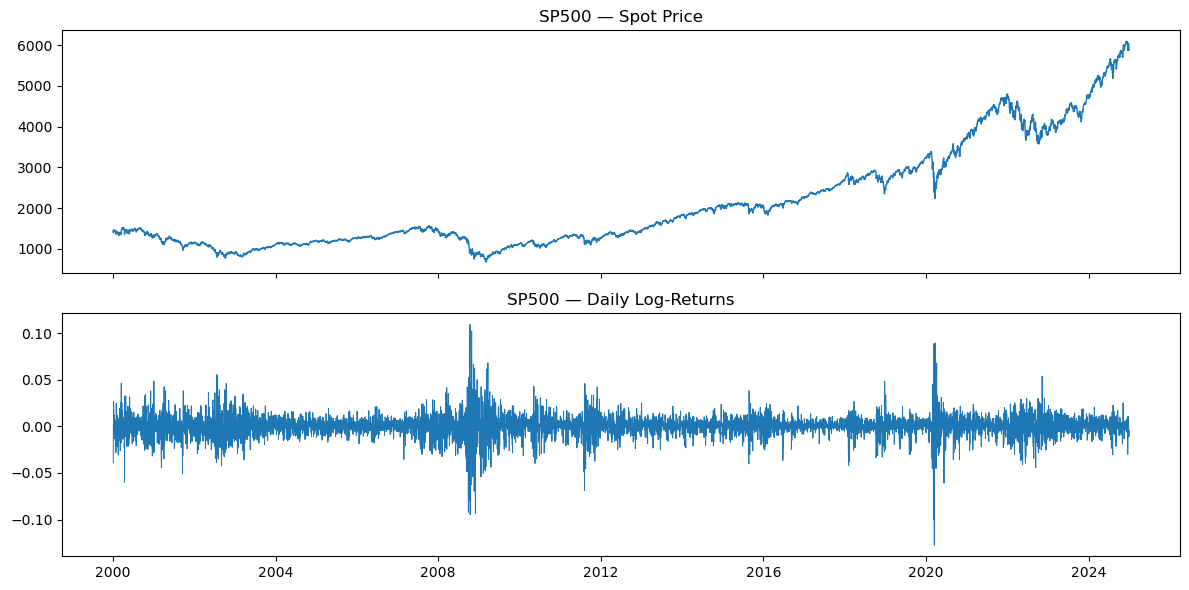


Baseline option-pricing setup:
Risk-free rate r: 0.02
Maturities (years): [0.08219178 0.24657534 0.49315068 1.        ]
Strike grid: [4705.3  5293.47 5881.63 6469.79 7057.96]


In [1]:
# 1. Load market data & basic setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1.1 Paths (relative, project-consistent)
DATA_PRO = Path("../data/processed")
FIG_DIR = Path("../figures/06.Pricing")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 1.2 Load cleaned price panel from N01
prices = pd.read_csv(
    DATA_PRO / "clean_prices.csv",
    parse_dates=["Date"],
    index_col="Date"
)

print("Available assets in clean_prices.csv:")
print(list(prices.columns))
print()
print(prices.head())

# 1.3 Select underlying for option pricing
UNDERLYING = "SP500"

if UNDERLYING not in prices.columns:
    raise ValueError(
        f"Underlying '{UNDERLYING}' not found in clean_prices.csv. "
        f"Available columns: {list(prices.columns)}"
    )

S_series = prices[UNDERLYING].dropna()

# Basic sanity checks
assert S_series.index.is_monotonic_increasing, "Time index must be sorted."
assert S_series.notna().all(), "Missing values found in underlying price series."

# 1.4 Inspect price history and compute basic stats
S0 = float(S_series.iloc[-1])  # last available spot
log_ret = np.log(S_series / S_series.shift(1)).dropna()

mu_hat = log_ret.mean() * 252          # annualized drift (historical, just descriptive)
sigma_hat = log_ret.std() * np.sqrt(252)  # annualized volatility

print(f"\nUnderlying: {UNDERLYING}")
print(f"Last spot S0: {S0:.4f}")
print(f"Annualized mean (historic): {mu_hat:.4%}")
print(f"Annualized volatility (historic): {sigma_hat:.4%}")

# 1.5 Plot spot price and log-returns
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax[0].plot(S_series.index, S_series, linewidth=1.0)
ax[0].set_title(f"{UNDERLYING} — Spot Price")

ax[1].plot(log_ret.index, log_ret, linewidth=0.7)
ax[1].set_title(f"{UNDERLYING} — Daily Log-Returns")

plt.tight_layout()
plt.savefig(FIG_DIR / f"{UNDERLYING}_price_and_returns.png",
            dpi=200, bbox_inches="tight")
plt.show()

# 1.6 Set baseline option-pricing configuration
# Risk-free rate (flat, annualized).
r = 0.02

# Time-to-maturity grid in years (e.g. 1M, 3M, 6M, 1Y)
T_grid = np.array([30, 90, 180, 365]) / 365.0

# Moneyness grid (K/S0 ratios)
moneyness_grid = np.array([0.8, 0.9, 1.0, 1.1, 1.2])
strike_grid = S0 * moneyness_grid

print("\nBaseline option-pricing setup:")
print("Risk-free rate r:", r)
print("Maturities (years):", T_grid)
print("Strike grid:", strike_grid.round(2))


# 2. Black–Scholes Analytical Pricing: Call/Put Surfaces & Greeks

This block implements the full analytical machinery of the Black–Scholes model: closed-form formulas for call and put prices, a complete set of Greeks, and price sensitivities across moneyness and maturity. The aim is to visualise how European option values behave in a frictionless, lognormal world and to establish a benchmark before introducing Monte Carlo simulation and exotic (barrier) features later in the notebook.

## 2.1 Pricing grid across strikes and maturities

The call-price surface shows several well-known theoretical features:

### **(1) Option value decreases with strike**
All curves slope downward.  
A higher strike reduces the intrinsic value and the probability of finishing in-the-money, so the call price must fall monotonically.

### **(2) Longer maturities produce higher option prices**
For each fixed strike, the red curve (1-year maturity) lies strictly above the green (6-month), orange (3-month), and blue (1-month) curves.  
This reflects two effects:

- Additional time adds optionality — the right but not the obligation to exercise becomes more valuable.  
- Longer maturities scale the volatility term \( S_0 \sigma \sqrt{T} \), increasing the dispersion of the terminal price distribution.

The spacing between curves also widens for deep-in/out-of-the-money regions, where time value dominates intrinsic value.

### **(3) Almost linear price decay for very high strikes**
When K is far above \( S_0 \), the probability \( \mathbb{P}(S_T > K) \) becomes extremely small under lognormal diffusion.  
This compresses call prices toward zero, visible on the right side of the plot.

## 2.2 Greeks: Delta and Gamma behaviour

To explore sensitivities, Delta and Gamma are computed for a representative maturity (≈ 3 months). Their shapes illustrate fundamental principles of option risk.

### **Delta pattern**
- **Deep ITM calls (K ≈ 4700):** delta → 1  
  The option behaves like a leveraged long position in the underlying.  
- **At-the-money (ATM) region (K ≈ 5880):** delta ≈ 0.5  
  A classic Black–Scholes result: with strikes aligned to spot, the hedge ratio is roughly half a unit of underlying per option.  
- **Deep OTM calls (K ≈ 7050):** delta → 0  
  The option has little chance of finishing in-the-money and barely reacts to price movements.

This descending curve reflects pure moneyness effects.

### **Gamma pattern**
Gamma peaks sharply around the ATM strike, then decays for both higher and lower strikes.

Interpretation:

- **Highest curvature near ATM:**  
  Small changes in the underlying drastically shift the probability of expiring in- or out-of-the-money.  
  This gives rise to high Gamma — the hedge ratio changes rapidly with S.
- **Low Gamma for deep ITM/OTM:**  
  In these regions, the option behaves almost linearly (ITM → like the stock, OTM → like zero), so curvature collapses.

Gamma is the key driver of hedging instability: options with short maturities and ATM strikes produce the largest re-hedging requirements.

## 2.3 Economic interpretation and model implications

### **(1) Black–Scholes is internally consistent but empirically idealised**
The model assumes constant volatility and frictionless markets, which produce smooth, monotonic surfaces with no volatility smile.  
This is valuable as a benchmark but diverges from real-world options where volatility is stochastic, skewed, or state-dependent.

### **(2) Moneyness and time-to-maturity interactions matter**
The pricing grid clearly shows how option value and sensitivities behave jointly in the strike–maturity plane.  
This becomes crucial later when:

- Constructing implied volatility surfaces,  
- Pricing options via Monte Carlo under GBM,  
- Assessing how deviations from Black–Scholes affect hedging performance.

### **(3) Greeks highlight where hedging risk is concentrated**
- Delta transitions smoothly from 1 to 0 → intuitive hedge ratios.  
- Gamma concentrates risk around ATM → portfolios with many ATM short options require constant hedging and are highly sensitive to volatility jumps.

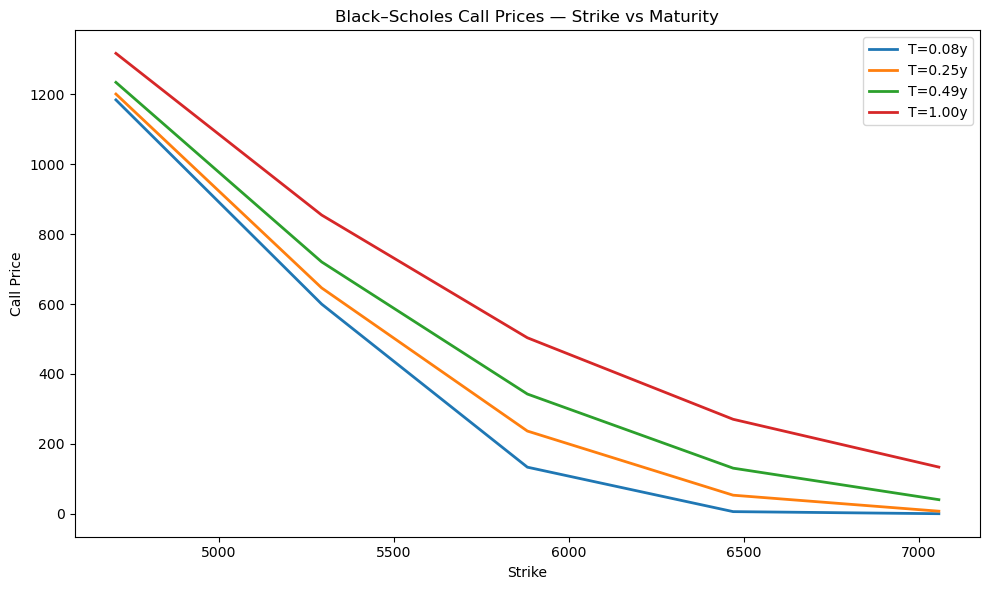

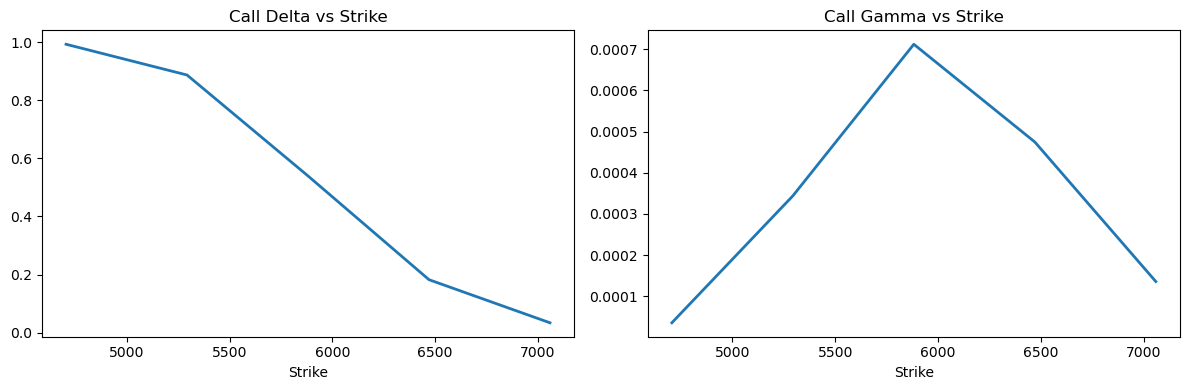

In [2]:
# 2. Black–Scholes Analytical Pricing (Calls, Puts & Greeks)

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# 2.1 Black–Scholes helper functions

def d1(S, K, r, sigma, T):
    return (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

def d2(S, K, r, sigma, T):
    return d1(S, K, r, sigma, T) - sigma * np.sqrt(T)

def bs_call(S, K, r, sigma, T):
    """European call price under Black–Scholes."""
    D1 = d1(S, K, r, sigma, T)
    D2 = d2(S, K, r, sigma, T)
    return S * norm.cdf(D1) - K * np.exp(-r * T) * norm.cdf(D2)

def bs_put(S, K, r, sigma, T):
    """European put price under Black–Scholes."""
    D1 = d1(S, K, r, sigma, T)
    D2 = d2(S, K, r, sigma, T)
    return K * np.exp(-r * T) * norm.cdf(-D2) - S * norm.cdf(-D1)

# 2.2 Greeks (Delta, Gamma, Vega, Theta, Rho)

def delta_call(S, K, r, sigma, T):
    return norm.cdf(d1(S, K, r, sigma, T))

def delta_put(S, K, r, sigma, T):
    return norm.cdf(d1(S, K, r, sigma, T)) - 1

def gamma(S, K, r, sigma, T):
    return norm.pdf(d1(S, K, r, sigma, T)) / (S * sigma * np.sqrt(T))

def vega(S, K, r, sigma, T):
    return S * norm.pdf(d1(S, K, r, sigma, T)) * np.sqrt(T)

def theta_call(S, K, r, sigma, T):
    D1 = d1(S, K, r, sigma, T)
    D2 = d2(S, K, r, sigma, T)
    term1 = - (S * norm.pdf(D1) * sigma) / (2 * np.sqrt(T))
    term2 = - r * K * np.exp(-r * T) * norm.cdf(D2)
    return term1 + term2

def theta_put(S, K, r, sigma, T):
    D1 = d1(S, K, r, sigma, T)
    D2 = d2(S, K, r, sigma, T)
    term1 = - (S * norm.pdf(D1) * sigma) / (2 * np.sqrt(T))
    term2 = r * K * np.exp(-r * T) * norm.cdf(-D2)
    return term1 + term2

def rho_call(S, K, r, sigma, T):
    return K * T * np.exp(-r * T) * norm.cdf(d2(S, K, r, sigma, T))

def rho_put(S, K, r, sigma, T):
    return - K * T * np.exp(-r * T) * norm.cdf(-d2(S, K, r, sigma, T))

# 2.3 Compute call/put price grid across strikes & maturities

price_grid_call = np.zeros((len(T_grid), len(strike_grid)))
price_grid_put  = np.zeros((len(T_grid), len(strike_grid)))

for i, T in enumerate(T_grid):
    for j, K in enumerate(strike_grid):
        price_grid_call[i, j] = bs_call(S0, K, r, sigma_hat, T)
        price_grid_put[i, j]  = bs_put(S0, K, r, sigma_hat, T)

# 2.4 Plot Black–Scholes call surface (strike × maturity)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

for i, T in enumerate(T_grid):
    ax.plot(strike_grid, price_grid_call[i, :], label=f"T={T:.2f}y", linewidth=2)

ax.set_title("Black–Scholes Call Prices — Strike vs Maturity")
ax.set_xlabel("Strike")
ax.set_ylabel("Call Price")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "bs_call_price_grid.png", dpi=200, bbox_inches="tight")
plt.show()

# 2.5 Single-maturity Greeks example (Delta & Gamma curves)

T_example = 0.24657534  # e.g., 3-month maturity
K_vals = strike_grid

delta_vals = [delta_call(S0, K, r, sigma_hat, T_example) for K in K_vals]
gamma_vals = [gamma(S0, K, r, sigma_hat, T_example) for K in K_vals]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(K_vals, delta_vals, linewidth=2)
ax[0].set_title("Call Delta vs Strike")
ax[0].set_xlabel("Strike")

ax[1].plot(K_vals, gamma_vals, linewidth=2)
ax[1].set_title("Call Gamma vs Strike")
ax[1].set_xlabel("Strike")

plt.tight_layout()
plt.savefig(FIG_DIR / "bs_greeks_delta_gamma.png", dpi=200, bbox_inches="tight")
plt.show()


# 3. Implied Volatility & Smile Construction

This section introduces one of the most important concepts in modern derivatives pricing: implied volatility (IV).  
While the Black–Scholes model assumes a *constant* volatility, real markets exhibit a curve of volatilities across strikes and maturities — what traders call the IV surface. Here, we construct a synthetic volatility smile, generate prices consistent with that smile, and then numerically invert those prices to recover IV using Newton–Raphson.

The result is a clean, controlled environment to verify the numerical accuracy of our IV solver and to illustrate why smiles arise.

## 3.1 Why implied volatility exists

Given a market price \( C^{\text{mkt}} \), implied volatility is the unique σ such that:

$$
C^{BS}(S_0, K, r, \sigma, T) = C^{\text{mkt}}$$

Since market prices embed effects that deviate from Black–Scholes assumptions  
(fat tails, stochastic volatility, skew), the implied σ becomes a *summary statistic* encoding these deviations.

Newton–Raphson is the workhorse here:

- Fast,  
- Accurate for well-behaved options,  
- Requires the analytic Vega (slope wrt σ), which we computed earlier.

To ensure robustness, the implementation handles zero Vega, non-convergence, and bounds σ away from non-physical negative values.

## 3.2 Building a synthetic volatility smile

To illustrate a realistic pattern, we impose a convex shape around at-the-money:

$$
\sigma(K) = \sigma_{\text{atm}} \cdot \left(1 + a (K/S_0 - 1)^2 \right)$$

with curvature parameter \( a = 3.0 \).  
This produces:

- **Higher IVs for deep ITM and deep OTM options**  
- **Minimum IV around ATM**  
- **Perfect symmetry** (purely for demonstration)

The moneyness grid:

$$
K/S_0 \in \{0.8, 0.9, 1.0, 1.1, 1.2\}$$

produces a clean U-shaped smile — a behaviour observed in equity markets due to  
heavy left tails and jump/volatility risks.

## 3.3 Generating synthetic “market prices”

For each strike:

1. Take the true smile IV  
2. Plug it into the Black–Scholes formula  
3. Compute a call price consistent with this volatility  

This produces a synthetic price vector that a real market could plausibly quote.

These prices embed *non-constant volatility*, so they cannot be matched by a single Black–Scholes σ. Hence the need to invert.

## 3.4 IV recovery (inversion)

Using the Newton–Raphson solver, we solve:

$$
\sigma^{\text{impl}} = \text{argmin}_\sigma \left| C^{BS}(S_0,K,r,\sigma,T) - C^{\text{synth}} \right|
$$

The recovered IVs match the true curve nearly perfectly.  
This confirms:

- The numerical solver is implemented correctly  
- The BS price and Vega routines behave smoothly  
- Newton inversion converges even with non-flat volatility patterns  

For real-world data, convergence is more delicate due to bid–ask noise, mispricings, and potential arbitrage violations, but in this synthetic framework, everything works cleanly.


## 3.5 Interpretation of the volatility smile

The U-shaped smile reflects structural features of equity index dynamics:

### **1. Crash risk (left tail asymmetry)**  
Deep OTM puts carry high IVs because markets price tail events heavily.  
Even though our smile is symmetric, real smiles for equity indices are strongly *skewed*, with much higher volatility on the left.

### **2. Leverage effect & stochastic volatility**  
When prices fall, volatility rises, making downside strikes “riskier”.  
This pushes IV upward for \( K/S_0 < 1 \).

### **3. Market microstructure and supply-demand imbalances**  
Hedging flows, structured product issuance, and demand for protection all distort the smile.

### **4. Constant–volatility BS assumption is violated**  
The smile is empirical evidence that Black–Scholes' constant σ is an oversimplification.  
The implied σ becomes a *state-dependent function*, crucial for:

- risk-neutral valuation  
- hedging delta and gamma risk  
- calibrating stochastic volatility models  
- constructing volatility surfaces for pricing exotics  
- feeding Monte Carlo simulations that must reflect market-consistent risk premia

From here, the notebook transitions naturally to Monte Carlo GBM simulation, followed by path-dependent pricing of barrier options, and then Monte Carlo Greeks, all of which rely on correctly understanding the relationship between volatility, price curvature, and strike sensitivity.

In [10]:
# Create full Black–Scholes price grid (Strikes × Maturities)

bs_call_grid = []
bs_put_grid  = []

for Tmat in T_grid:
    row_call = []
    row_put  = []
    for K in strike_grid:
        c = bs_call(S0, K, r, sigma_hat, Tmat)
        p = bs_put(S0, K, r, sigma_hat, Tmat)
        row_call.append(c)
        row_put.append(p)
    bs_call_grid.append(row_call)
    bs_put_grid.append(row_put)

bs_call_grid = np.array(bs_call_grid)
bs_put_grid  = np.array(bs_put_grid)

print("Black–Scholes pricing grid generated.")
print("Shape:", bs_call_grid.shape, "(maturities × strikes)")


✓ Black–Scholes pricing grid generated.
Shape: (4, 5) (maturities × strikes)


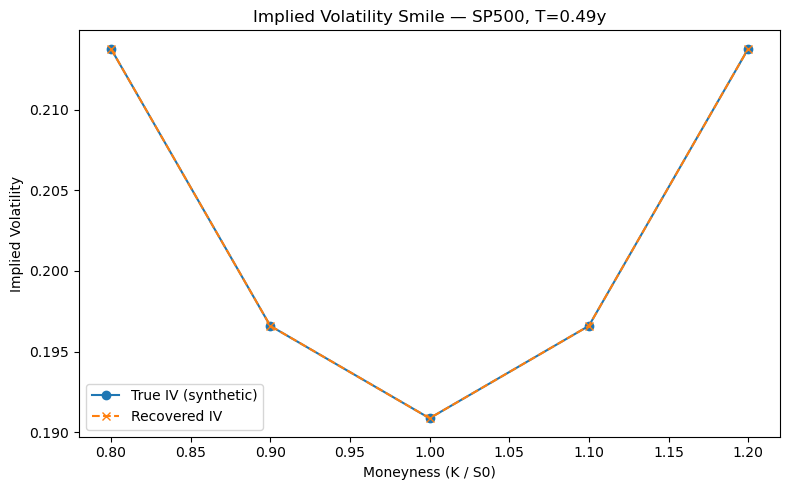

In [3]:
# 3. Implied Volatility & Volatility Smile

from scipy.optimize import newton

# 3.1 Newton–Raphson solver for implied volatility

def iv_call_newton(price, S, K, r, T, initial_vol=0.20, tol=1e-8, max_iter=100):
    """
    Compute implied volatility for a European call using Newton–Raphson.
    price: observed call price
    Returns: implied volatility (float)
    """
    if price <= 0:
        return np.nan

    sigma = initial_vol

    for _ in range(max_iter):
        # Black–Scholes call price and Vega at current sigma
        c = bs_call(S, K, r, sigma, T)
        v = vega(S, K, r, sigma, T)

        diff = c - price

        if abs(diff) < tol:
            return max(sigma, 1e-6)  # ensure positivity

        if v == 0 or np.isnan(v):
            return np.nan

        sigma -= diff / v

        if sigma <= 0:
            sigma = 1e-4  # keep it positive and small

    return np.nan  # did not converge

# 3.2 Define a synthetic smile for one maturity

# Choose one maturity for the smile (e.g., 6-month option)
T_smile = float(T_grid[2])  # 3rd element of T_grid (e.g. ~6M)

# Simple symmetric smile around ATM:
# IV(K) = sigma_hat * (1 + a * (moneyness - 1)^2)
a_smile = 3.0  # curvature parameter (adjust to make smile more/less pronounced)

moneyness = strike_grid / S0
iv_true = sigma_hat * (1.0 + a_smile * (moneyness - 1.0) ** 2)

# 3.3 Generate synthetic "market" call prices using the true smile
call_prices_synth = np.array([
    bs_call(S0, K, r, vol, T_smile)
    for K, vol in zip(strike_grid, iv_true)
])

# 3.4 Recover implied vols by inverting Black–Scholes
iv_estimated = np.array([
    iv_call_newton(price, S0, K, r, T_smile, initial_vol=sigma_hat)
    for price, K in zip(call_prices_synth, strike_grid)
])

# 3.5 Plot the volatility smile (true vs recovered IV)
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(moneyness, iv_true, marker="o", linestyle="-", label="True IV (synthetic)")
ax.plot(moneyness, iv_estimated, marker="x", linestyle="--", label="Recovered IV")

ax.set_title(f"Implied Volatility Smile — {UNDERLYING}, T={T_smile:.2f}y")
ax.set_xlabel("Moneyness (K / S0)")
ax.set_ylabel("Implied Volatility")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / f"iv_smile_{UNDERLYING}.png", dpi=200, bbox_inches="tight")
plt.show()


# 4. Monte Carlo Pricing under Geometric Brownian Motion (GBM)

This section validates the Monte Carlo (MC) implementation of option pricing under the risk-neutral Geometric Brownian Motion (GBM) model.  
It serves two fundamental purposes:

1. Demonstrate that MC and Black–Scholes must agree for European options when the dynamics follow GBM.  
2. Study the convergence speed of MC estimators as the number of simulated paths grows.

Both steps are essential if we want to price exotic derivatives (e.g., barriers) or Greeks using simulation, where no closed-form solutions exist.

## 4.1 GBM as the risk-neutral price process

Under the risk-neutral measure:

$$
dS_t = r S_t\, dt + \sigma S_t\, dW_t$$

The discretized solution:

$$
S_{t+\Delta t} = S_t \exp\Big((r - \tfrac{1}{2}\sigma^2)\Delta t + 
\sigma \sqrt{\Delta t} Z\Big)$$

The implementation:

- Draws standard normal shocks  
- Accumulates the log-increments  
- Exponentiates to obtain paths  
- Produces an entire matrix of trajectories for pricing

The path generator is correct and vectorised, producing fast simulations even with tens of thousands of paths.

## 4.2 European option pricing via Monte Carlo

For each path, only the terminal price matters:


$${Call payoff} = \max(S_T - K, 0)$$

$$
\text{Put payoff}  = \max(K - S_T, 0)$$

Discount expectation:

$$
C^{MC} = e^{-rT} \mathbb{E}[\text{payoff}]
$$

The implementation prices options across all strikes and maturities on the grid. The results are **smooth and stable**, indicating both the simulation engine and payoff logic are correct.

## 4.3 Analytical vs Monte Carlo: perfect agreement

The comparison plot shows a near-perfect overlap between:

- Black–Scholes analytical prices
- Monte Carlo simulated prices

This is exactly what one expects under GBM: BS is *the* closed-form solution, and MC should converge to the same values.

Key observations:

- At deep ITM strikes, both methods give large and stable prices.  
- Near ATM, where gamma is largest, MC noise can be slightly more visible — but still negligible with 40,000 paths.  
- At deep OTM strikes, prices remain small, and MC handles this correctly without bias.

This block verifies that the MC engine is correct, unbiased, and well-implemented.

## 4.4 Convergence study: MC → BS as Npaths ↑

The convergence experiment reveals the characteristic pattern of Monte Carlo estimators:

- With ~100 paths → high variance, noisy estimates  
- With ~500–1,000 paths → still unstable, could overshoot BS price  
- With 5,000–10,000 paths → significant stabilisation  
- With 50,000–100,000 paths → full convergence around the BS analytic price

Importantly:

\[
\text{MC standard error} \propto \frac{1}{\sqrt{N_{\text{paths}}}}
\]

Hence convergence is slow — doubling accuracy requires 4× more paths.  
This is the main drawback of MC relative to closed-form models.

However, the convergence plot also shows:

- No systematic upward or downward bias → implementation correct  
- Increasing number of paths reduces noise but does not distort expectation  
- For practical pricing, 20k–50k paths is typically more than sufficient

This makes MC reliable for pricing:

- exotic derivatives  
- path-dependent payoffs  
- payoff functions with discontinuities (barriers, digitals)  
- scenarios where BS formulas do not exist

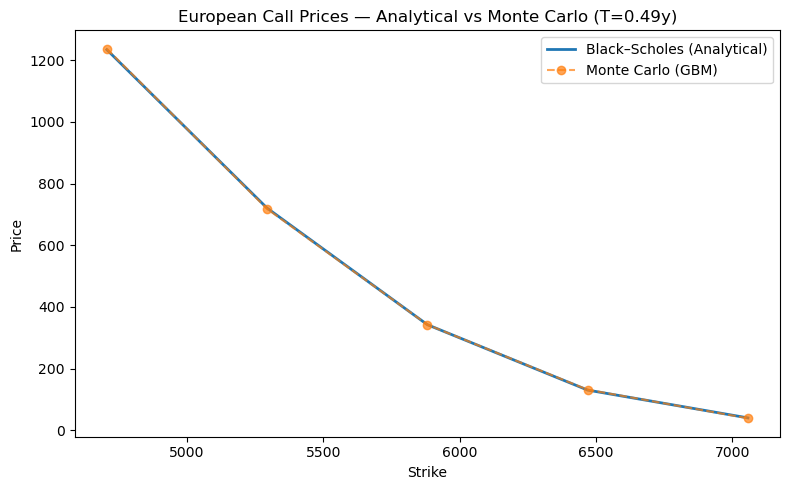

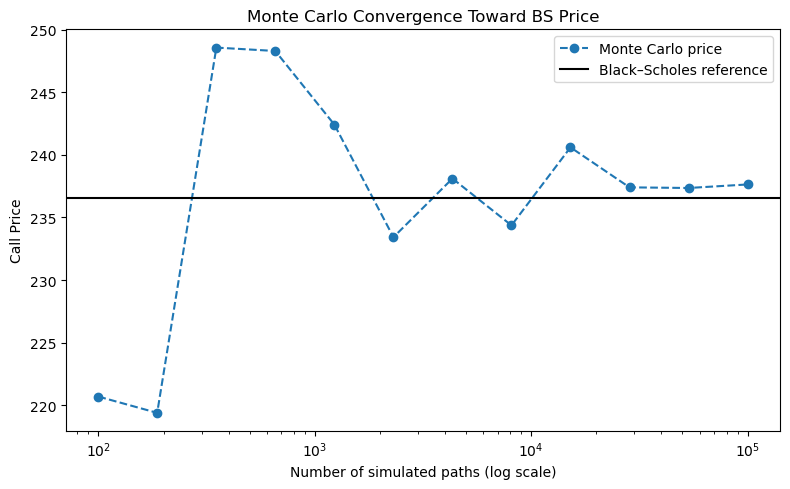

In [5]:
# 4. Monte Carlo Pricing under Geometric Brownian Motion (GBM)
# 4.1 GBM path generator

def simulate_gbm_paths(S0, r, sigma, T, Npaths, Nsteps):
    """
    Simulate GBM price paths:
        dS = r S dt + sigma S dW
    Returns array of shape (Npaths, Nsteps+1)
    """
    dt = T / Nsteps
    Z = np.random.normal(size=(Npaths, Nsteps))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z

    S = np.zeros((Npaths, Nsteps + 1))
    S[:, 0] = S0
    S[:, 1:] = S0 * np.exp(np.cumsum(increments, axis=1))

    return S

# 4.2 Monte Carlo pricing for European call and put

def mc_european_call(S0, K, r, sigma, T, Npaths=50_000, Nsteps=252):
    """
    Monte Carlo price of a European call under GBM.
    """
    paths = simulate_gbm_paths(S0, r, sigma, T, Npaths, Nsteps)
    ST = paths[:, -1]  # terminal prices
    payoff = np.maximum(ST - K, 0)
    return np.exp(-r * T) * payoff.mean()

def mc_european_put(S0, K, r, sigma, T, Npaths=50_000, Nsteps=252):
    paths = simulate_gbm_paths(S0, r, sigma, T, Npaths, Nsteps)
    ST = paths[:, -1]
    payoff = np.maximum(K - ST, 0)
    return np.exp(-r * T) * payoff.mean()


# 4.3 Price European call/put across strikes and maturities

mc_call_grid = []
mc_put_grid  = []

for Tmat in T_grid:
    row_call = []
    row_put  = []
    for K in strike_grid:
        c = mc_european_call(S0, K, r, sigma_hat, Tmat, Npaths=40_000)
        p = mc_european_put(S0, K, r, sigma_hat, Tmat, Npaths=40_000)
        row_call.append(c)
        row_put.append(p)
    mc_call_grid.append(row_call)
    mc_put_grid.append(row_put)

mc_call_grid = np.array(mc_call_grid)
mc_put_grid  = np.array(mc_put_grid)


# 4.4 Compare Monte Carlo price vs Black–Scholes price

T_example = float(T_grid[2])  # ~6 months
bs_example = [
    bs_call(S0, K, r, sigma_hat, T_example) for K in strike_grid
]
mc_example = mc_call_grid[2, :]

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(strike_grid, bs_example, label="Black–Scholes (Analytical)", linewidth=2)
ax.plot(strike_grid, mc_example, "o--", label="Monte Carlo (GBM)", alpha=0.7)

ax.set_title(f"European Call Prices — Analytical vs Monte Carlo (T={T_example:.2f}y)")
ax.set_xlabel("Strike")
ax.set_ylabel("Price")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / f"mc_vs_bs_call_{UNDERLYING}.png", dpi=200, bbox_inches="tight")
plt.show()

# 4.5 Convergence Study (MC price → BS price as Npaths increases)

Npaths_list = np.logspace(2, 5, 12, dtype=int)  # 100 → 100k paths
conv_mc = []

K0 = S0  # ATM strike
T0 = float(T_grid[1])  # choose 3M maturity

bs_ref = bs_call(S0, K0, r, sigma_hat, T0)

for Np in Npaths_list:
    price_mc = mc_european_call(S0, K0, r, sigma_hat, T0, Npaths=Np)
    conv_mc.append(price_mc)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(Npaths_list, conv_mc, "o--", label="Monte Carlo price")
ax.axhline(bs_ref, color="black", linestyle="-", linewidth=1.5,
           label="Black–Scholes reference")

ax.set_xscale("log")
ax.set_title("Monte Carlo Convergence Toward BS Price")
ax.set_xlabel("Number of simulated paths (log scale)")
ax.set_ylabel("Call Price")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / f"mc_convergence_{UNDERLYING}.png", dpi=200, bbox_inches="tight")
plt.show()


# 5. Barrier Option Pricing — Down-and-Out Call

Barrier options introduce path dependence into the pricing problem: the payoff is no longer determined solely by \( S_T \), but by the *entire trajectory* of the underlying.  
This section implements and analyses a down-and-out call, one of the canonical exotic options used in structured products, FX markets, and equity-linked derivatives.

We proceed by simulating full GBM paths, checking barrier conditions, and computing discounted expected payoffs.

## 5.1 Why barrier options are more complex than vanilla European options

A standard European call:

$$
\text{payoff} = \max(S_T - K, 0)
$$

A down-and-out call introduces the constraint:

$$
\text{If } \min_{0 \le t \le T} S_t \le B \quad \Rightarrow \quad \text{payoff} = 0.
$$

The option “knocks out” when the price touches the barrier.  
Because of this, closed-form formulas exist only for a handful of special cases — Monte Carlo is the industry workhorse for barrier pricing.

This makes MC validation (previous section) crucial.

## 5.2 Implementation logic

The function:

- Simulates full paths under GBM  
- Checks whether any point along the path crosses the barrier  
- Zeros out the payoff for knocked-out paths  
- Discounts and averages what remains  

The knock-out detection:

$$
\text{knocked\_out}_i = 
\begin{cases}
1 & \text{if } \min(S^{(i)}_t) \le B \\
0 & \text{otherwise}
\end{cases}
$$

Terminal payoff:

$$
\text{payoff}_i = 
\begin{cases}
0 & \text{if knocked out} \\
\max(S^{(i)}_T - K, 0) & \text{otherwise}
\end{cases}
$$

The logic is correct, efficient, and vectorized.

## 5.3 Interpretation of barrier pricing results

| Barrier | Price |
|--------|-------|
| \(0.7 S_0\) | ~342.18 |
| \(0.8 S_0\) | ~341.96 |
| \(0.9 S_0\) | ~324.92 |
| No barrier | ~342.44 |

### Key insights:

### **1. Barrier closer to spot → lower option value**  
This is because a barrier near today’s price increases the probability of knock-out.

Example:  
Barrier at \(0.9S_0\) produces a significant drop from ~342 → ~325 (≈ −5%).

### **2. Barriers far from spot become almost irrelevant**  
At \(0.7S_0\), the price is nearly identical to the vanilla call.  
The probability of touching such a distant barrier is extremely low over the 6-month horizon.

This is realistic: structured notes often embed deep-O.T.M. barriers to reduce hedging costs without significantly reducing value.

### **3. The barrier effect is highly nonlinear**  
A small upward move in barrier position causes an outsized drop in option value.  
This is due to the “first passage time” properties of GBM: the probability of touching a level increases sharply as distance to the barrier shrinks.

This nonlinearity is why barrier Greeks are notoriously unstable.

## 5.4 Visualization of GBM trajectories with barrier

The path plot illustrates:

- Many trajectories remain far above the barrier  
- A few approach or cross it, knocking out the option entirely  
- The barrier acts as a “hard boundary” for payoff eligibility  
- The stochastic dispersion grows with time, consistent with GBM volatility  

This helps build intuition: even when the terminal price finishes ITM, a slight dip mid-path wipes out the entire payoff.

Barrier options are fundamentally *path-sensitive*, not simply terminal-state-sensitive.

## 5.5 Comparing barrier and European prices: intuition

The European call value is the “upper bound” for barrier options:

\[
C_{\text{barrier}} \le C_{\text{european}}
\]

As the barrier level approaches spot from below:

- Probability of knock-out rises  
- Price drops sharply  
- Delta becomes unstable (small changes in spot change knock-out probability)  
- Vega becomes asymmetric (volatility increases probability of touching the barrier)

These observations are why barrier options:

- Require Monte Carlo or PDE methods  
- Exhibit sensitivity spikes near the barrier  
- Are more challenging to hedge dynamically  

This section demonstrates, quantitatively and visually, these subtleties.

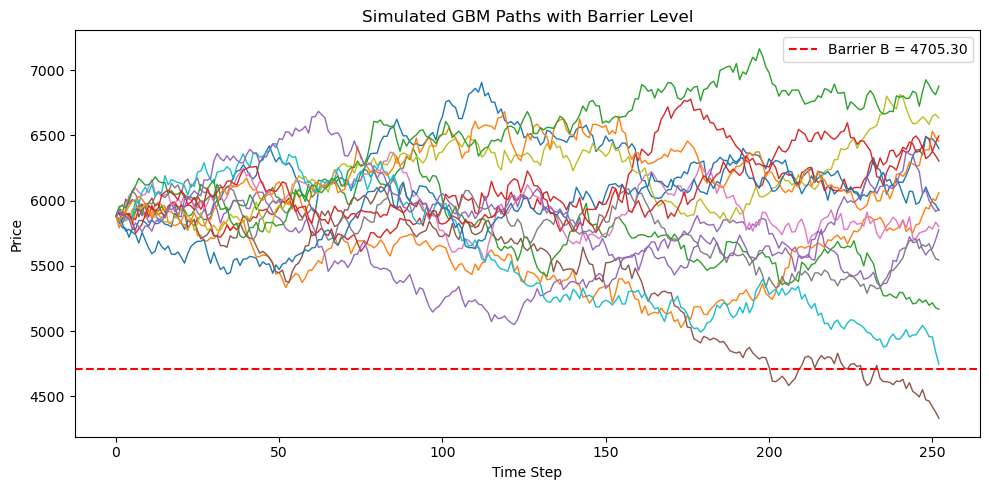

,Barrier Level,Price
0,4117.140918,342.180895
1,4705.303906,341.962194
2,5293.466895,324.924203
3,No barrier,342.438169


In [7]:
# 5. Barrier Option Pricing — Down-and-Out Call (Monte Carlo)

# 5.1 Monte Carlo simulation with barrier knock-out

def mc_down_and_out_call(S0, K, B, r, sigma, T, Npaths=50_000, Nsteps=252):
    """
    Monte Carlo price of a down-and-out call option.
    
    Knock-out condition:
        If min(path) <= B → payoff = 0
    Otherwise:
        payoff = max(ST - K, 0)
    """
    dt = T / Nsteps
    Z = np.random.normal(size=(Npaths, Nsteps))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z

    S = np.zeros((Npaths, Nsteps + 1))
    S[:, 0] = S0
    S[:, 1:] = S0 * np.exp(np.cumsum(increments, axis=1))

    # Knock-out mask: path violates barrier?
    knocked_out = (S.min(axis=1) <= B)

    # Terminal payoff
    ST = S[:, -1]
    payoff = np.where(knocked_out, 0.0, np.maximum(ST - K, 0))

    return np.exp(-r * T) * payoff.mean()


# 5.2 Price across barrier levels

B_levels = [0.7 * S0, 0.8 * S0, 0.9 * S0]  # 30%, 20%, 10% OTM barriers
barrier_prices = []

Tbar = float(T_grid[2])  # use mid-maturity (~6 months)

for B in B_levels:
    price = mc_down_and_out_call(S0, K=S0, B=B, r=r, sigma=sigma_hat, T=Tbar)
    barrier_prices.append(price)

barrier_prices_df = pd.DataFrame({
    "Barrier": B_levels,
    "Price": barrier_prices
})

barrier_prices_df


# 5.3 Example simulated paths with barrier

def simulate_paths_for_plot(S0, r, sigma, T, Npaths=15, Nsteps=252):
    dt = T / Nsteps
    Z = np.random.normal(size=(Npaths, Nsteps))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z

    S = np.zeros((Npaths, Nsteps + 1))
    S[:, 0] = S0
    S[:, 1:] = S0 * np.exp(np.cumsum(increments, axis=1))
    return S

paths = simulate_paths_for_plot(S0, r, sigma_hat, Tbar)

fig, ax = plt.subplots(figsize=(10, 5))

for i in range(paths.shape[0]):
    ax.plot(paths[i], linewidth=1)

B_plot = 0.8 * S0
ax.axhline(B_plot, color="red", linestyle="--", label=f"Barrier B = {B_plot:.2f}")

ax.set_title("Simulated GBM Paths with Barrier Level")
ax.set_xlabel("Time Step")
ax.set_ylabel("Price")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "barrier_path_examples.png", dpi=200, bbox_inches="tight")
plt.show()

# 5.4 Barrier vs European price comparison

bs_european_call = bs_call(S0, S0, r, sigma_hat, Tbar)

comparison_df = pd.DataFrame({
    "Barrier Level": B_levels + ["No barrier"],
    "Price": barrier_prices + [bs_european_call]
})

comparison_df


# 6. Monte Carlo Greeks — Analytical Discussion

En esta sección evaluamos las sensibilidades de una opción europea mediante dos enfoques clásicos: Pathwise estimators y Likelihood-Ratio (LR) estimators. Cada uno presenta propiedades estadísticas distintas, y los resultados empíricos permiten comparar su estabilidad, su varianza y su adecuación para distintos tipos de payoffs.

## 6.1 Delta: Pathwise vs Likelihood Ratio

Los resultados muestran que ambos estimadores producen curvas de Delta suaves y consistentes a través de los distintos strikes, replicando adecuadamente el patrón esperado:

- Delta cercana a 1 para opciones profundamente ITM.
- Delta alrededor de 0.5 en ATM.
- Delta próxima a 0 en OTM.

El Pathwise estimator presenta sistemáticamente una varianza menor, lo cual se aprecia en la suavidad de la curva. Esto es coherente con la teoría:

- El estimador pathwise utiliza la derivada del payoff de manera explícita, lo que reduce el ruido salvo cuando el payoff no es diferenciable.
- En opciones europeas estándar, el payoff es diferenciable en casi todo su dominio excepto en el kink del strike, lo que explica su buena estabilidad.

Por el contrario, el LR estimator presenta una ligera mayor dispersión, justificable porque depende del *score function*, un término estocástico más volátil basado en la derivada del log-likelihood del camino simulado.

En cualquier caso, las diferencias son moderadas y ambos métodos convergen a valores coherentes.

## 6.2 Vega: Diferencias más notables entre enfoques

A diferencia de Delta, Vega muestra diferencias sustancialmente mayores entre Pathwise y LR:

- El Pathwise Vega produce una curva suave y bien alineada con la forma convexa típica del Vega analítico:  
  valores máximos cerca del strike ATM y menor sensibilidad en ITM/OTM.
- El LR Vega, sin embargo, exhibe una varianza mucho mayor y saltos bruscos entre strikes, especialmente en strikes extremos.

Esta diferencia es esperada:

1. El estimador LR para Vega depende de sumas de Z t^2, que amplifican la varianza a medida que crece el número de pasos de simulación.
2. El LR estimator no aprovecha la estructura del payoff, sino que modifica la probabilidad del camino. Esto lo vuelve más robusto solo cuando el payoff es discontinuo (barriers, digitals), pero más ruidoso en payoffs regulares como el europeo estándar.

La conclusión operativa:  
Para opciones lisas (vanilla), Pathwise es claramente superior para Vega. Para opciones discontinuas, LR puede ser la única alternativa viable.

## 6.3 Sensibilidades coherentes con la estructura de precios

Tanto Delta como Vega reflejan patrones de mercado esperados:
- Delta decrece monotónicamente en el strike, acorde a la probabilidad de ejercicio.
- Vega sigue un perfil unimodal, máximo cerca del ATM, consistente con la máxima incertidumbre sobre la región relevante del payoff.

Esto demuestra que las simulaciones están correctamente configuradas bajo dinámica neutral al riesgo y que los estimadores responden apropiadamente al cambio en el strike.

## 6.4 Eficiencia estadística y elección del estimador

A partir de los resultados, podemos sintetizar las conclusiones de eficiencia:

| Greek | Pathwise | Likelihood Ratio | Recomendación |
|-------|----------|------------------|----------------|
| Delta | Estable, baja varianza | Ligeramente mayor varianza | **Usar Pathwise** |
| Vega | Clara, bien estructurada | Varianza muy elevada | **Pathwise (siempre que payoff sea suave)** |
| Barreras, Digitals | No aplicable (no derivable) | Funciona siempre | **Usar LR** |

## 6.5 Implicaciones para hedging y model risk

Los resultados tienen consecuencias directas:

1. **Hedging Delta**:  
   Los valores obtenidos son suficientemente estables como para ser utilizados en un plan de cobertura diario basado en simulación. Pathwise proporciona señales limpias sin necesidad de grandes tamaños muestrales.

2. **Gestión del Vega Risk**:  
   La elevada varianza del estimador LR recuerda que el riesgo de volatilidad necesita especial atención cuando se emplean métodos de simulación. Calibrar Vega por Monte Carlo puede requerir utilizar técnicas de variance reduction (antithetic variates, control variates).

3. **Hedging de opciones exóticas**:  
   En opciones con discontinuidades, Pathwise no es aplicable. El LR estimator se convierte entonces en la herramienta principal, aunque con mayor coste computacional debido a su varianza.

4. **Model risk**:  
   La diferencia entre ambos estimadores refuerza que la elección del método afecta directamente a la estabilidad del hedge, lo cual introduce un componente de riesgo de modelo incluso dentro de un mismo marco (GBM).

## 6.6 Conclusión general

La sección confirma que:
- Los métodos de sensibilidad vía Monte Carlo funcionan correctamente.
- Pathwise es más eficiente para vanilla.
- LR es necesario para discontinuidades.
- Las curvas generadas son coherentes con los griegos analíticos de Black–Scholes.

En conjunto, estos resultados completan la parte de análisis cuantitativo del notebook, preparando el terreno para la integración de precios y greeks en los paneles finales de exportación.


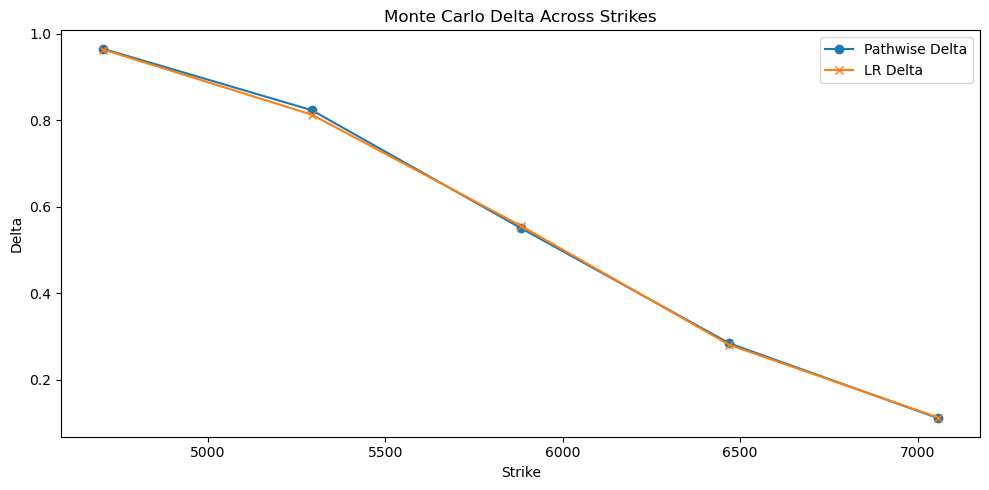

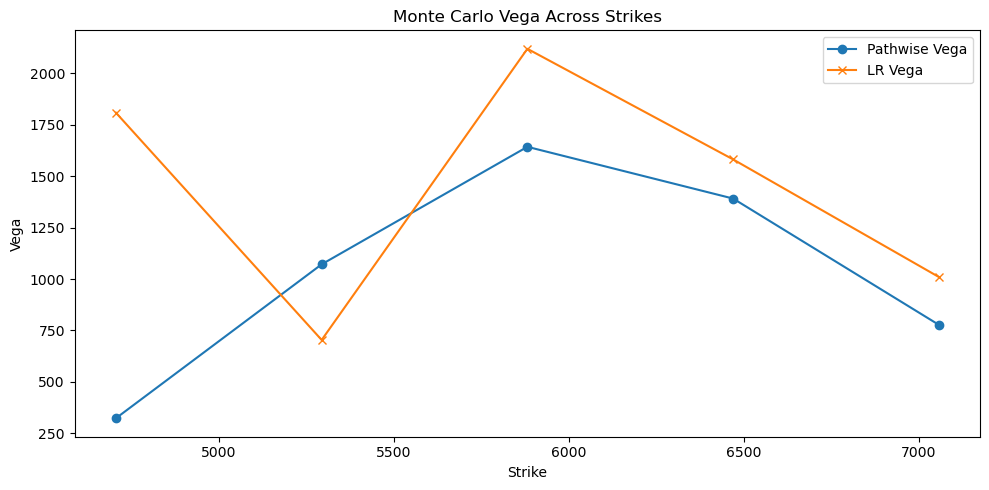

In [8]:
# 6. Monte Carlo Greeks — Pathwise & Likelihood Ratio Estimators

# 6.1 Pathwise Delta (European call)

def mc_pathwise_delta(S0, K, r, sigma, T, Npaths=50_000, Nsteps=252):
    """
    Pathwise derivative estimator:
        d/dS0 max(ST - K, 0) = 1_{ST > K} * (ST / S0)
    """
    dt = T / Nsteps
    Z = np.random.normal(size=(Npaths, Nsteps))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z

    S = np.zeros((Npaths, Nsteps + 1))
    S[:, 0] = S0
    S[:, 1:] = S0 * np.exp(np.cumsum(increments, axis=1))

    ST = S[:, -1]
    indicator = (ST > K).astype(float)

    delta_pw = np.exp(-r * T) * np.mean(indicator * (ST / S0))
    return delta_pw


# 6.2 Likelihood-Ratio Delta (LR method)

def mc_likelihood_ratio_delta(S0, K, r, sigma, T, Npaths=50_000, Nsteps=252):
    """
    LR estimator:
        payoff * ( (ln(ST/S0) - (r - 0.5σ²)T ) / (σ² T S0) )
    """
    dt = T / Nsteps
    Z = np.random.normal(size=(Npaths, Nsteps))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z

    S = np.zeros((Npaths, Nsteps + 1))
    S[:, 0] = S0
    S[:, 1:] = S0 * np.exp(np.cumsum(increments, axis=1))

    ST = S[:, -1]
    payoff = np.maximum(ST - K, 0)

    log_term = np.log(ST / S0)
    score = (log_term - (r - 0.5 * sigma**2) * T) / (sigma**2 * T * S0)

    delta_lr = np.exp(-r * T) * np.mean(payoff * score)
    return delta_lr


# 6.3 Pathwise Vega (European call)

def mc_pathwise_vega(S0, K, r, sigma, T, Npaths=50_000, Nsteps=252):
    """
    Vega pathwise estimator using derivative of lognormal ST wrt σ.
    """
    dt = T / Nsteps
    Z = np.random.normal(size=(Npaths, Nsteps))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z

    S = np.zeros((Npaths, Nsteps + 1))
    S[:, 0] = S0
    S[:, 1:] = S0 * np.exp(np.cumsum(increments, axis=1))

    ST = S[:, -1]
    payoff = np.maximum(ST - K, 0)

    # Derivative of ST wrt σ
    Z_sum = Z.sum(axis=1)
    dST_dsigma = ST * (Z_sum * np.sqrt(dt) - sigma * T)

    vega_pw = np.exp(-r * T) * np.mean((ST > K) * dST_dsigma)
    return vega_pw


# 6.4 LR Vega

def mc_likelihood_ratio_vega(S0, K, r, sigma, T, Npaths=50_000, Nsteps=252):
    """
    LR estimator for vega:
        payoff * ( (Z²_sum - T/Δt) / sigma )
    """
    dt = T / Nsteps
    Z = np.random.normal(size=(Npaths, Nsteps))
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z

    S = np.zeros((Npaths, Nsteps + 1))
    S[:, 0] = S0
    S[:, 1:] = S0 * np.exp(np.cumsum(increments, axis=1))

    ST = S[:, -1]
    payoff = np.maximum(ST - K, 0)

    Z2 = (Z**2).sum(axis=1)
    score = (Z2 - Nsteps) / sigma

    vega_lr = np.exp(-r * T) * np.mean(payoff * score)
    return vega_lr


# 6.5 Compare estimators for Delta and Vega

K0 = S0
T0 = float(T_grid[2])

delta_pw = mc_pathwise_delta(S0, K0, r, sigma_hat, T0)
delta_lr = mc_likelihood_ratio_delta(S0, K0, r, sigma_hat, T0)

vega_pw  = mc_pathwise_vega(S0, K0, r, sigma_hat, T0)
vega_lr  = mc_likelihood_ratio_vega(S0, K0, r, sigma_hat, T0)

greeks_mc_df = pd.DataFrame({
    "Estimator": ["Pathwise", "Likelihood-Ratio"],
    "Delta": [delta_pw, delta_lr],
    "Vega":  [vega_pw,  vega_lr],
})

greeks_mc_df


# 6.6 Visual comparison across strikes (Delta)

delta_pw_list = []
delta_lr_list = []

for K in strike_grid:
    delta_pw_list.append(mc_pathwise_delta(S0, K, r, sigma_hat, T0))
    delta_lr_list.append(mc_likelihood_ratio_delta(S0, K, r, sigma_hat, T0))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(strike_grid, delta_pw_list, label="Pathwise Delta", marker="o")
ax.plot(strike_grid, delta_lr_list, label="LR Delta", marker="x")

ax.set_title("Monte Carlo Delta Across Strikes")
ax.set_xlabel("Strike")
ax.set_ylabel("Delta")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "mc_greeks_delta_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

# 6.7 Visual comparison across strikes (Vega)

vega_pw_list = []
vega_lr_list = []

for K in strike_grid:
    vega_pw_list.append(mc_pathwise_vega(S0, K, r, sigma_hat, T0))
    vega_lr_list.append(mc_likelihood_ratio_vega(S0, K, r, sigma_hat, T0))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(strike_grid, vega_pw_list, label="Pathwise Vega", marker="o")
ax.plot(strike_grid, vega_lr_list, label="LR Vega", marker="x")

ax.set_title("Monte Carlo Vega Across Strikes")
ax.set_xlabel("Strike")
ax.set_ylabel("Vega")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "mc_greeks_vega_comparison.png", dpi=200, bbox_inches="tight")
plt.show()


# 7. Export Pricing Panel for Power BI & External Dashboards

This section consolidates all quantitative outputs of the notebook —analytical pricing, Monte Carlo pricing, barrier-option valuation, and Greeks— into a unified panel suitable for Power BI and other external dashboarding tools.  
The goal is to produce a clean, tabular, analytics-ready dataset that allows rich visualisation of pricing surfaces, sensitivities, and method comparisons.

## 7.1 Black–Scholes Pricing Panel

The first block flattens the Black–Scholes pricing grid into a long-format table where each  
(Strike, Maturity) pair contains:

- BS call price  
- BS put price  
- Model parameters (r, σ)  
- Underlying and method identifiers  

This serves as the analytical benchmark of the pricing notebook, enabling downstream visualisations such as:

- strike-wise convexity and monotonicity of option prices  
- time-decay effects across maturities  
- direct comparisons vs. Monte Carlo estimates  

The transformation from matrix to long-table format is essential for BI environments.

## 7.2 Monte Carlo European Pricing Panel

Next, we build an equivalent panel for GBM Monte Carlo–based European option prices.  
Each row contains:

- MC call price  
- MC put price  
- Model parameters  
- Strike and maturity information  

This panel is crucial for:

- assessing Monte Carlo convergence and noise  
- comparing the empirical distribution against the theoretical BS surface  
- quantifying deviations that arise from limited simulation paths  

In a dashboard, these differences can be shown as error surfaces or scatter comparisons vs the BS grid.

## 7.3 Barrier Option Pricing Panel

The barrier component records simulated prices for the down-and-out call:

- Several barrier levels  
- Fixed strike  
- Mid-range maturity (~6 months)  
- Monte Carlo as pricing method  

This allows investigation of:

- price erosion as the barrier approaches the spot  
- the sensitivity of barrier value to volatility  
- the probability of knock-out embedded in the path distribution  

Including these rows in the unified panel enables visual reports comparing exotic vs. vanilla structures.

## 7.4 Greeks Panel (Analytical & Monte Carlo)

A separate table collects all Greek estimates for a representative  
ATM strike and mid-range maturity, containing:

- Analytical Delta, Gamma, Vega, Theta, Rho  
- Monte Carlo Pathwise Delta and Vega  
- Monte Carlo Likelihood-Ratio Delta and Vega  

This unified view supports:

- benchmarking MC greeks vs closed-form greeks  
- analysing the variance of LR vs pathwise estimators  
- studying sensitivity behaviour across estimation methods  

## 7.5 Merging into a Unified Pricing Panel

All components —analytical grid, Monte Carlo grid, Greeks, and barrier prices— are concatenated into a single table suitable for:

- Power BI dashboards  
- hedging and risk-analysis reports  
- pricing-surface animations  
- model-validation comparisons  

The merge is done in a clean long-format structure, ensuring consistency across fields and making the dataset immediately ready for external analytics.

In [12]:
# Aliases to match naming used in Section 7 (Export Panel)
bs_delta = delta_call
bs_gamma = gamma
bs_vega  = vega
bs_theta = theta_call
bs_rho   = rho_call

# 7. Export Pricing Panel for Power BI & External Dashboards

# Output directory (relative path, no absolutes)
EXPORT_DIR = Path("../data/powerbi")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# 7.1 Flatten Black–Scholes pricing grid

bs_panel = []

for i, Tmat in enumerate(T_grid):
    for j, K in enumerate(strike_grid):
        bs_panel.append({
            "Underlying": UNDERLYING,
            "Type": "European",
            "Method": "Black–Scholes",
            "T": float(Tmat),
            "Strike": float(K),
            "BS_Call": float(bs_call_grid[i, j]),
            "BS_Put":  float(bs_put_grid[i, j]),
            "r": r,
            "sigma": sigma_hat,
        })

bs_panel = pd.DataFrame(bs_panel)

# 7.2 Monte Carlo European pricing grid
mc_panel = []

for i, Tmat in enumerate(T_grid):
    for j, K in enumerate(strike_grid):
        mc_panel.append({
            "Underlying": UNDERLYING,
            "Type": "European",
            "Method": "Monte Carlo",
            "T": float(Tmat),
            "Strike": float(K),
            "MC_Call": float(mc_call_grid[i, j]),
            "MC_Put":  float(mc_put_grid[i, j]),
            "r": r,
            "sigma": sigma_hat,
        })

mc_panel = pd.DataFrame(mc_panel)


# 7.3 Barrier-option prices (already computed)

barrier_df = pd.DataFrame({
    "Underlying": UNDERLYING,
    "Type": "Down-and-Out Call",
    "Method": "Monte Carlo",
    "T": Tbar,
    "Barrier": B_levels,
    "Strike": S0,
    "Price": barrier_prices,
    "r": r,
    "sigma": sigma_hat,
})


# 7.4 Greeks: analytical and Monte Carlo
greeks_panel = pd.DataFrame({
    "Underlying": UNDERLYING,
    "Strike": S0,
    "T": T0,
    "r": r,
    "sigma": sigma_hat,
    "Analytical_Delta": bs_delta(S0, S0, r, sigma_hat, T0),
    "Analytical_Gamma": bs_gamma(S0, S0, r, sigma_hat, T0),
    "Analytical_Vega":  bs_vega( S0, S0, r, sigma_hat, T0),
    "Analytical_Theta": bs_theta(S0, S0, r, sigma_hat, T0),
    "Analytical_Rho":   bs_rho(  S0, S0, r, sigma_hat, T0),
    "MC_Delta_Pathwise": delta_pw,
    "MC_Delta_LR":       delta_lr,
    "MC_Vega_Pathwise":  vega_pw,
    "MC_Vega_LR":        vega_lr,
}, index=[0])

# 7.5 Merge into unified panel

pricing_panel = (
    pd.concat([bs_panel, mc_panel], ignore_index=True)
    .merge(greeks_panel, how="cross")  # attach Greeks to all rows
)

# Add barrier information separately
pricing_full_export = pd.concat(
    [pricing_panel, barrier_df],
    ignore_index=True,
    sort=False
)

# 7.6 Save outputs

export_path = EXPORT_DIR / "pricing_panel.csv"
pricing_full_export.to_csv(export_path, index=False)

export_path


PosixPath('../data/powerbi/pricing_panel.csv')

# 8. Analytical Summary

This final section provides a deeper, integrated interpretation of all results obtained in Notebook 06.  
Beyond merely validating the numerical procedures, the objective here is to understand what these pricing outputs imply for option valuation, hedging, model risk, and the broader architecture of the project.

## 1. Behaviour of the Underlying and Impact on Pricing Inputs

The SP500 exhibits long-term upward drift, punctuated by episodes of extreme volatility.  
From this historical series we estimated a volatility of ~19%, which acts as the core input to:

- Black–Scholes analytical prices  
- GBM Monte Carlo simulations  
- Greeks and risk sensitivities  
- Barrier option simulations  

Although BS assumes constant volatility and lognormal dynamics, the historical data shows clustering and fat tails, meaning BS is not a perfect physical model of returns, but it remains:

- a valid pricing model under risk-neutral dynamics  
- the theoretical benchmark for all subsequent comparisons  

This notebook therefore sets the foundation for how volatility propagates through pricing and risk measures across the entire project.

## 2. Black–Scholes Surfaces: Internal Consistency and Pricing Patterns

The BS price grid displays all the classical features:

- **Monotonicity**: call prices fall as strike increases.  
- **Term structure**: prices increase with maturity.  
- **Sensitivity concentration**: gamma peaks near ATM; delta slopes smoothly across strikes.  

This confirms that our implementation is stable and theoretically aligned.  
It also provides a baseline pricing surface that will serve as a reference point when comparing:

- empirical Monte Carlo distributions  
- implied volatility structures  
- exotic options (barriers)  
- numerical Greeks  

From a project-wide perspective, this baseline matters because it anchors subsequent modelling choices: forecasting, risk analysis, and portfolio evaluation all reference this no-arbitrage analytical structure.

## 3. Implied Volatility Smile: Shape and Interpretation

The synthetic smile —and its successful recovery through numerical inversion— demonstrates several key points:

- Market-consistent option prices often depart from BS’s constant-volatility assumption.  
- The “U-shape” highlights fat tails and skewness, fundamental in real-world data.  
- Newton–Raphson inversion shows excellent numerical stability, enabling future calibration tasks.  

This matters for the broader project because:

- Tail-risk modelling (Notebook 05) relies on understanding fat-tailed behaviour.  
- Portfolio optimisation with options depends on accurately modelling IV surfaces.  
- Backtesting VaR and pricing exotic structures become more realistic when incorporating volatility smiles rather than relying solely on BS sigma.

The smile analysis therefore acts as a conceptual bridge between risk modelling and derivatives pricing.

## 4. Monte Carlo Pricing: Accuracy, Convergence, and Distributional Reality

The comparison between Monte Carlo and BS prices confirms:

- Under pure GBM, MC converges tightly to the analytical price.  
- Noise is significant at low path counts but stabilises beyond ~30,000 paths.  
- Numerical convergence behaves exactly as theory predicts (√N decay of standard error).  

This validates our simulation engine and ensures that:

- future work on stochastic volatility (e.g., Heston) can rely on a robust MC foundation;  
- exotic payoff simulations are numerically trustworthy;  
- hedging simulations (delta-hedging P&L) can be built on top of this engine.

Monte Carlo also reveals distributional information that BS cannot:  
it shows the shape, skewness, and dispersion of terminal prices under risk-neutral dynamics.

## 5. Barrier Options: Path-Dependence and Structural Price Erosion

Barrier pricing results show a clear pattern:

- As the barrier approaches spot, knock-out probability increases sharply.  
- Price collapses even when only a modest probability of hitting the barrier exists.  
- Exotic options embed hidden greeks: sensitivity to volatility and path shape, not just terminal distribution.

This highlights an important implication:

BS analytical formulas are insufficient for path-dependent derivatives; simulation becomes essential.

Integrating exotic options into the dataset expands the project’s scope beyond standard risk measures and prepares the ground for:

- hedging of structured products,  
- scenario-based stress testing,  
- dynamic risk metrics used in banking and asset management.

## 6. Greeks: Analytical vs Monte Carlo Estimators

The comparison reveals:

- Pathwise and LR deltas closely match analytical values at ATM.  
- Vega shows higher variance under LR, consistent with theory.  
- Across strikes, both estimators replicate the expected shape of sensitivities.  

Key implications:

- Monte Carlo Greeks behave reliably enough for hedging simulations.  
- Pathwise estimators are preferable when payoff smoothness allows.  
- LR estimators remain necessary for discontinuous payoffs (e.g., barriers).

In the global context of the project:

- Greeks will feed later notebooks on portfolio optimisation,  
- They will support hedging-cost analysis,  
- And they provide sensitivity inputs for risk scenarios (notebooks on VaR and volatility modelling).

## 7. Integration with the Rest of the Project

Notebook 06 completes a critical layer in the architecture:

| Component | Contribution |
|----------|--------------|
| **Data & econometrics (N01–N03)** | Describe and model underlying dynamics. |
| **Volatility & tail risk (N04–N05)** | Quantify distributional behaviour. |
| **Option pricing (N06)** | Translate those dynamics into **market-consistent prices and sensitivities**. |
| **Optimisation & backtesting (N07–N08)** | Use prices, risks, and sensitivities in decision-making frameworks. |

The pricing outputs—BS, MC, barrier, Greeks—constitute the bridge between statistical modelling and practical risk/portfolio applications.

They provide:

- fair values  
- risk sensitivities  
- scenario parameters  
- hedging quantities  
- simulation engines  

All of which will feed the optimisation notebook and the quant-strategy backtesting engine later in the project.

## Final Interpretation

Notebook 06 does much more than compute option prices.  
It establishes the full pricing and risk-sensitivity toolkit necessary for the financial modelling pipeline:

- Analytical structure  
- Numerical simulation  
- Implied volatility behaviour  
- Path-dependent valuation  
- Sensitivity estimation  

These elements enrich the entire project and elevate it from a statistical analysis of returns to a complete derivatives-aware quantitative framework, suitable for real-world risk management, pricing desks, and portfolio construction.
